In [1]:
# pip install tushare
# pip install keras_sequential_ascii

In [1]:
# Part 1 - Data Preprocessing
# Importing the libraries导入需要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tushare as ts
import keras
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model 

In [2]:
# set the seed_num
import json
import os
import random
import tensorflow as tf
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)
from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [3]:
# early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=2)

mc = ModelCheckpoint(filepath='best_model.h5',
                     monitor='val_acc',
                     mode='max',
                     verbose=1,
                     save_best_only=True) 

In [4]:
# 读取数据
data = pd.read_csv('IBM.csv') #这里改成自己的文件路径
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,23.68750,24.53125,23.62500,24.50000,6.590755,7041600
1,1990-01-03,24.68750,24.87500,24.59375,24.71875,6.649599,9464000
2,1990-01-04,24.75000,25.09375,24.71875,25.00000,6.725261,9674800
3,1990-01-05,24.96875,25.40625,24.87500,24.93750,6.708448,7570000
4,1990-01-08,24.81250,25.21875,24.81250,25.09375,6.750481,4625200


In [5]:
#显示数据集的前几行，查看样式
print(data.head())
all_data = data.iloc[:, 1:7]
all_data.head()

         Date      Open      High       Low     Close  Adj Close   Volume
0  1990-01-02  23.68750  24.53125  23.62500  24.50000   6.590755  7041600
1  1990-01-03  24.68750  24.87500  24.59375  24.71875   6.649599  9464000
2  1990-01-04  24.75000  25.09375  24.71875  25.00000   6.725261  9674800
3  1990-01-05  24.96875  25.40625  24.87500  24.93750   6.708448  7570000
4  1990-01-08  24.81250  25.21875  24.81250  25.09375   6.750481  4625200


,Open,High,Low,Close,Adj Close,Volume
0,23.68750,24.53125,23.62500,24.50000,6.590755,7041600
1,24.68750,24.87500,24.59375,24.71875,6.649599,9464000
2,24.75000,25.09375,24.71875,25.00000,6.725261,9674800
3,24.96875,25.40625,24.87500,24.93750,6.708448,7570000
4,24.81250,25.21875,24.81250,25.09375,6.750481,4625200


In [6]:
all_data = all_data.loc[:,['Open', 'Close', "High", "Low", "Volume", "Adj Close"]]

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7278 entries, 0 to 7277
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7278 non-null   float64
 1   Close      7278 non-null   float64
 2   High       7278 non-null   float64
 3   Low        7278 non-null   float64
 4   Volume     7278 non-null   int64  
 5   Adj Close  7278 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 341.3 KB


In [8]:
all_data.describe()

,Open,Close,High,Low,Volume,Adj Close
count,7278.000000,7278.000000,7278.000000,7278.000000,7.278000e+03,7278.000000
mean,97.111166,97.150037,98.032100,96.250604,7.374148e+06,75.033509
std,56.722461,56.748006,57.089386,56.386388,4.612416e+06,51.126516
min,10.250000,10.250000,10.437500,10.156250,6.528000e+05,5.663548
25%,38.812500,38.937500,39.593750,38.414062,4.477975e+06,25.615211
50%,94.642502,94.584999,95.606251,93.555001,6.245800e+06,67.877994
75%,144.217502,144.120003,145.000000,143.114997,8.843625e+06,126.280022
max,215.380005,215.800003,215.899994,214.300003,6.944470e+07,175.264389


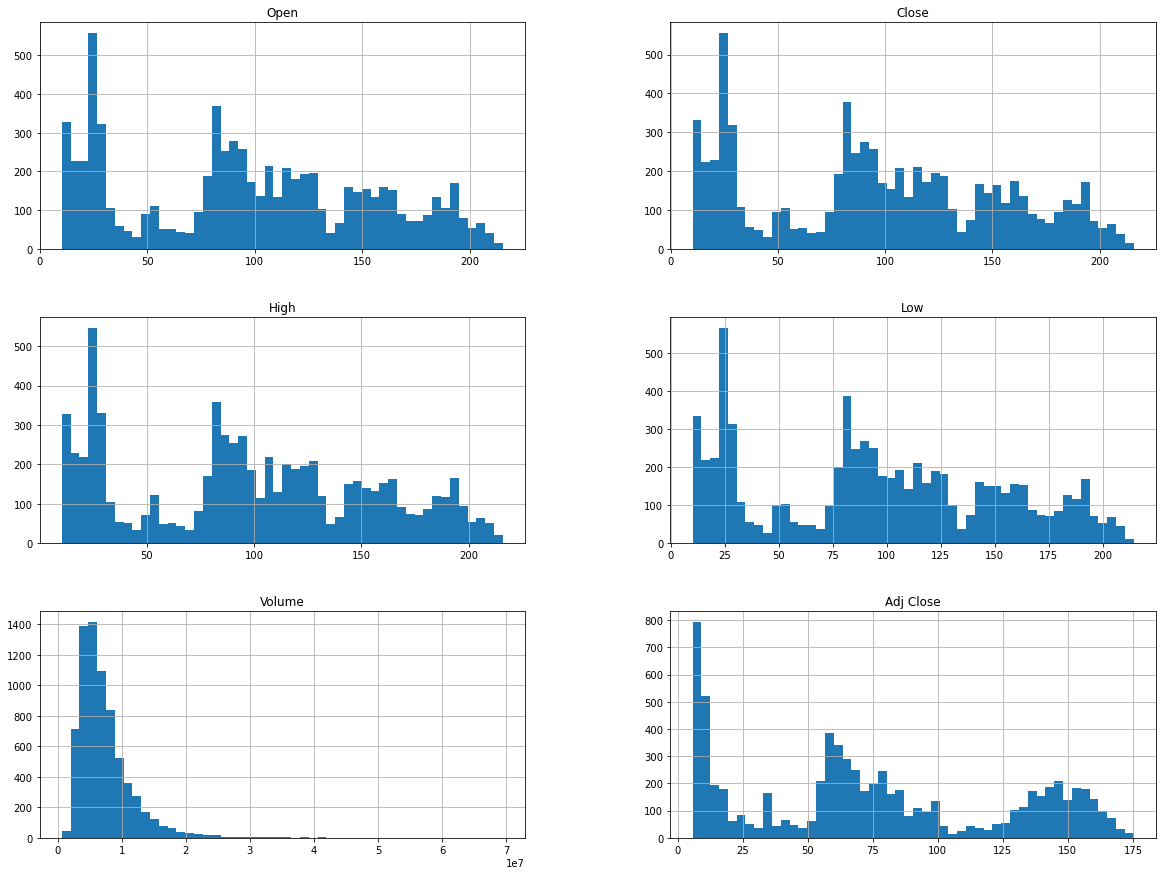

In [8]:
all_data.hist(bins = 50 , figsize = (20, 15))
plt.show()

In [9]:
# Feature Scaling特征归一化，归一化很重要，消除量纲的差异。
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1),)
all_data_scaled = sc.fit_transform(all_data)
print(all_data_scaled)
print('训练数据长度是:',len(all_data_scaled))

[[0.06550724 0.0693262  0.06859524 0.06597679 0.0928714  0.005467  ]
 [0.07038219 0.07039041 0.0702683  0.07072222 0.12808485 0.00581395]
 [0.07068688 0.0717587  0.07133297 0.07133454 0.13114916 0.00626007]
 ...
 [0.54082776 0.53801992 0.54419908 0.53758075 0.04988378 0.67910305]
 [0.54043776 0.53490633 0.54264162 0.53694392 0.05973814 0.67532949]
 [0.53336909 0.54093895 0.54025676 0.53567033 0.06621564 0.6826408 ]]
训练数据长度是: 7278


In [10]:
# 设置循环核时间步timestep为60。
features = []
labels = []
for i in range(60, len(all_data_scaled)):
    features.append(all_data_scaled[i-60:i, ])
    labels.append(all_data_scaled[i, 1])
features, labels = np.array(features), np.array(labels)
print(features.shape)
features = np.reshape(features, (features.shape[0], features.shape[1], -1))
print(features.shape)
x_train,x_val,x_test,y_train,y_val,y_test= features[:6550],features[6550 :6914 ],features[6914:],labels[:6550],labels[6550 :6914],labels[6914:]
print('shape of x_train:',x_train.shape)
print('shape of x_val:',x_val.shape)
print('shape of x_test:',x_test.shape)
print('shape of y_train:',y_train.shape)
print('shape of y_val:',y_val.shape)
print('shape of y_test:',y_test.shape)

print(y_train)
all_data_scaled[60]

(7218, 60, 6)
(7218, 60, 6)
shape of x_train: (6550, 60, 6)
shape of x_val: (364, 60, 6)
shape of x_test: (304, 60, 6)
shape of y_train: (6550,)
shape of y_val: (364,)
shape of y_test: (304,)
[0.07890416 0.07905619 0.07920822 ... 0.67063977 0.65750422 0.66990997]


array([0.07708526, 0.07890416, 0.07802519, 0.07730459, 0.07517746,
       0.01076212])

In [11]:
# Part 2 - Building the LSTM
# Importing the Keras libraries and packages
import warnings
warnings.filterwarnings("ignore")
import keras 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 6))) #输入特征的维数
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

In [12]:
#编译训练模型重点#
#编译训练模型重点#
#编译训练模型重点#
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [13]:
print(regressor.summary()) # Summarize Model 模型可视化

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [14]:
from keras_sequential_ascii import keras2ascii
keras2ascii(regressor)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     60    6
                LSTM   LLLLL -------------------     11400    15.8%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                LSTM   LLLLL -------------------     20200    28.0%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                LSTM   LLLLL -------------------     20200    28.0%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                LSTM   LLLLL -------------------     20200    28.0%
                tanh   #####          50
             Dropout    | || -------------------         0     0.0%
                       #####          50
             

In [18]:
# import keras #回调函数
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = {'batch':[], 'epoch':[]}
#         self.accuracy = {'batch':[], 'epoch':[]}
#         self.val_loss = {'batch':[], 'epoch':[]}
#         self.val_acc = {'batch':[], 'epoch':[]}

#     def on_batch_end(self, batch, logs={}):
#         self.losses['batch'].append(logs.get('loss'))
#         self.accuracy['batch'].append(logs.get('acc'))
#         self.val_loss['batch'].append(logs.get('val_loss'))
#         self.val_acc['batch'].append(logs.get('val_acc'))

#     def on_epoch_end(self, batch, logs={}):
#         self.losses['epoch'].append(logs.get('loss'))
#         self.accuracy['epoch'].append(logs.get('acc'))
#         self.val_loss['epoch'].append(logs.get('val_loss'))
#         self.val_acc['epoch'].append(logs.get('val_acc'))

#     def loss_plot(self, loss_type):
#         iters = range(len(self.losses[loss_type]))
#         plt.figure()
#         # loss
#         plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
#         if loss_type == 'epoch':
#             # val_loss
#             plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
#         plt.grid(True)
#         plt.xlabel(loss_type)
#         plt.ylabel('acc-loss')
#         plt.legend(loc="upper right")
#         plt.show()

In [14]:
# fit to the training set
history=regressor.fit(x_train, y_train, epochs=200, batch_size=32,validation_data=(x_val, y_val),callbacks=[mc, earlystop])

Epoch 1/200
205/205 [==============================] - 10s 25ms/step - loss: 0.0063 - val_loss: 0.0026
Epoch 2/200
205/205 [==============================] - 4s 21ms/step - loss: 0.0025 - val_loss: 8.0776e-04
Epoch 3/200
205/205 [==============================] - 4s 20ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/200
205/205 [==============================] - 4s 20ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/200
205/205 [==============================] - 4s 19ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 6/200
205/205 [==============================] - 4s 19ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/200
205/205 [==============================] - 4s 19ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 8/200
205/205 [==============================] - 4s 20ms/step - loss: 0.0015 - val_loss: 3.3087e-04
Epoch 9/200
205/205 [==============================] - 4s 20ms/step - loss: 0.0015 - val_loss: 4.3756e-04
Epoch 10/200
205/205 [==============================] - 4s 20ms/step 

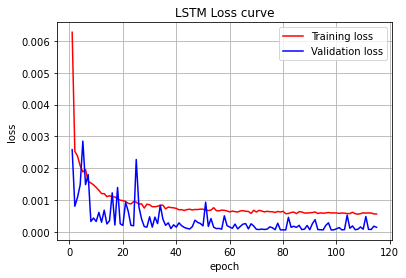

In [22]:
#画损失曲线图
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.title('LSTM Loss curve')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
sc_one = MinMaxScaler(feature_range = (0, 1))
sc_one.fit_transform(all_data.iloc[:, 1:2])
predicted_stock_train = regressor.predict(x_train)
predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
predicted_stock_test = regressor.predict(x_test)
predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)
real_price_train=sc_one.inverse_transform(np.reshape(y_train,(-1,1)))
real_price_test=sc_one.inverse_transform(np.reshape(y_test,(-1,1)))

10/10 [==============================] - 0s 11ms/step


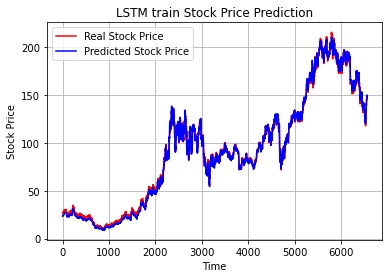

In [24]:
# Visualising the test results
plt.plot(real_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('LSTM train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

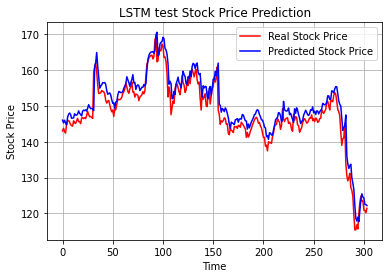

In [25]:
# Visualising the test results
plt.plot(real_price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('LSTM test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_test, real_price_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_stock_test, real_price_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_test, real_price_test)

r2=r2_score(predicted_stock_test, real_price_test)

print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)

LSTM模型的均方误差是: 9.654063
LSTM模型的均方根误差是: 3.107099
LSTM模型的平均绝对误差是: 2.518549
LSTM模型的R-squared是: 0.885584


In [25]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [26]:
#GRU
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],6)))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
print(regressorGRU.summary()) # Summarize Model 模型可视化

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 50)            8700      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

In [28]:
from keras_sequential_ascii import keras2ascii
keras2ascii(regressorGRU)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     60    6
                 GRU   LLLLL -------------------      8700    15.9%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                 GRU   LLLLL -------------------     15300    28.0%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                 GRU   LLLLL -------------------     15300    28.0%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                 GRU   LLLLL -------------------     15300    28.0%
                tanh   #####          50
             Dropout    | || -------------------         0     0.0%
                       #####          50
             

In [29]:
from keras.utils import plot_model 
plot_model(regressorGRU, to_file='model.png', show_shapes=True, show_layer_names=True) # plot my model

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [30]:
history=regressorGRU.fit(x_train, y_train, epochs=200, batch_size=32,validation_data=(x_val, y_val),callbacks=[mc, earlystop])

Epoch 1/200
205/205 [==============================] - 4s 17ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 2/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0020 - val_loss: 9.6750e-04
Epoch 5/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 5.6850e-04
Epoch 6/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 6.9000e-04
Epoch 7/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 8/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0015 - val_loss: 4.5999e-04
Epoch 9/200
205/205 [==============================] - 2s 12ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/200
205/205 [==============================] - 2s 12ms/st

Epoch 76/200
205/205 [==============================] - 2s 12ms/step - loss: 6.0225e-04 - val_loss: 2.1741e-04
Epoch 77/200
205/205 [==============================] - 2s 12ms/step - loss: 5.8411e-04 - val_loss: 7.0784e-05
Epoch 78/200
205/205 [==============================] - 2s 12ms/step - loss: 6.1102e-04 - val_loss: 1.8366e-04
Epoch 79/200
205/205 [==============================] - 2s 12ms/step - loss: 5.8680e-04 - val_loss: 1.2933e-04
Epoch 80/200
205/205 [==============================] - 2s 12ms/step - loss: 6.1835e-04 - val_loss: 6.6306e-05
Epoch 81/200
205/205 [==============================] - 2s 12ms/step - loss: 5.5408e-04 - val_loss: 1.3499e-04
Epoch 82/200
205/205 [==============================] - 2s 12ms/step - loss: 5.5011e-04 - val_loss: 4.4497e-04
Epoch 83/200
205/205 [==============================] - 2s 12ms/step - loss: 6.0797e-04 - val_loss: 2.6264e-04
Epoch 84/200
205/205 [==============================] - 2s 12ms/step - loss: 6.0649e-04 - val_loss: 9.4510e-05
E

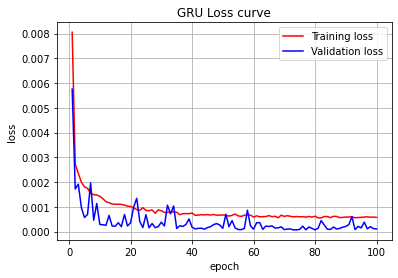

In [31]:
#画损失曲线图
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.title('GRU Loss curve')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [32]:
sc_one = MinMaxScaler(feature_range = (0, 1))
sc_one.fit_transform(all_data.iloc[:, 1:2])
predicted_stock_train = regressorGRU.predict(x_train)
predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
predicted_stock_test = regressorGRU.predict(x_test)
predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)
real_price_train=sc_one.inverse_transform(np.reshape(y_train,(-1,1)))
real_price_test=sc_one.inverse_transform(np.reshape(y_test,(-1,1)))

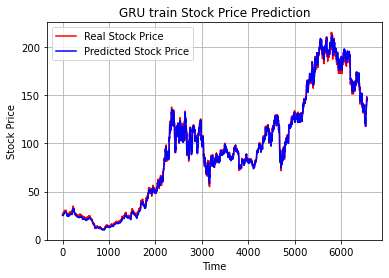

In [33]:
# Visualising the test results
plt.plot(real_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('GRU train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

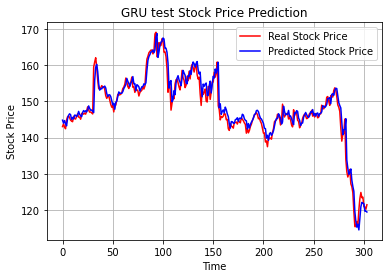

In [34]:
# Visualising the test results
plt.plot(real_price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('GRU test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_test, real_price_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_stock_test, real_price_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_test, real_price_test)

r2=r2_score(predicted_stock_test, real_price_test)

print('GRU模型的均方误差是: %.6f' % mse)
print('GRU模型的均方根误差是: %.6f' % rmse)
print('GRU模型的平均绝对误差是: %.6f' % mae)
print('GRU模型的R-squared是: %.6f' % r2)

GRU模型的均方误差是: 5.316634
GRU模型的均方根误差是: 2.305783
GRU模型的平均绝对误差是: 1.557126
GRU模型的R-squared是: 0.939961


In [39]:
a=np.array(range(10)).reshape(2,5)
b=np.array(range(10)).reshape(2,5)
c=np.stack((a,b))
c.shape

(2, 2, 5)

In [36]:
# BiLSTM
regressorBiLSTM = Sequential()
# firt LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1],6), merge_mode='concat'))
regressorBiLSTM.add(Dropout(0.2))
# second LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# third LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.2))
# fourth LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50)))
regressorBiLSTM.add(Dropout(0.2))
# output layer
regressorBiLSTM.add(Dense(units=1))
# compile the RNN
regressorBiLSTM.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
print(regressorBiLSTM.summary()) # Summarize Model 模型可视化

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 60, 100)           22800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 100)           60400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 100)           60400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)              

In [38]:
from keras_sequential_ascii import keras2ascii
keras2ascii(regressorBiLSTM)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     60    6
       Bidirectional   ????? -------------------     22800    11.2%
                       #####     60  100
             Dropout    | || -------------------         0     0.0%
                       #####     60  100
       Bidirectional   ????? -------------------     60400    29.6%
                       #####     60  100
             Dropout    | || -------------------         0     0.0%
                       #####     60  100
       Bidirectional   ????? -------------------     60400    29.6%
                       #####     60  100
             Dropout    | || -------------------         0     0.0%
                       #####     60  100
       Bidirectional   ????? -------------------     60400    29.6%
                       #####         100
             Dropout    | || -------------------         0     0.0%
                       #####         100
             

In [39]:
# fit to the training set
history=regressorBiLSTM.fit(x_train, y_train, epochs=200, batch_size=32,validation_data=(x_val, y_val),callbacks=[mc, earlystop])

Epoch 1/200
205/205 [==============================] - 8s 38ms/step - loss: 0.0046 - val_loss: 9.0049e-04
Epoch 2/200
205/205 [==============================] - 5s 25ms/step - loss: 0.0020 - val_loss: 5.0071e-04
Epoch 3/200
205/205 [==============================] - 5s 25ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/200
205/205 [==============================] - 5s 25ms/step - loss: 0.0014 - val_loss: 4.2354e-04
Epoch 5/200
205/205 [==============================] - 5s 25ms/step - loss: 0.0013 - val_loss: 4.2634e-04
Epoch 6/200
205/205 [==============================] - 5s 24ms/step - loss: 0.0012 - val_loss: 2.9994e-04
Epoch 7/200
205/205 [==============================] - 5s 24ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 8/200
205/205 [==============================] - 5s 24ms/step - loss: 0.0011 - val_loss: 2.5135e-04
Epoch 9/200
205/205 [==============================] - 5s 24ms/step - loss: 0.0010 - val_loss: 9.0409e-04
Epoch 10/200
205/205 [==============================] 

205/205 [==============================] - 5s 25ms/step - loss: 4.0541e-04 - val_loss: 2.0850e-04
Epoch 76/200
205/205 [==============================] - 5s 24ms/step - loss: 4.3859e-04 - val_loss: 2.9656e-04
Epoch 77/200
205/205 [==============================] - 5s 24ms/step - loss: 3.9677e-04 - val_loss: 3.1495e-04
Epoch 78/200
205/205 [==============================] - 5s 24ms/step - loss: 4.2225e-04 - val_loss: 2.3008e-04
Epoch 79/200
205/205 [==============================] - 5s 24ms/step - loss: 4.0010e-04 - val_loss: 0.0010
Epoch 80/200
205/205 [==============================] - 5s 25ms/step - loss: 4.2115e-04 - val_loss: 3.2908e-04
Epoch 81/200
205/205 [==============================] - 5s 25ms/step - loss: 3.7430e-04 - val_loss: 9.9743e-05
Epoch 82/200
205/205 [==============================] - 5s 25ms/step - loss: 4.1765e-04 - val_loss: 2.7567e-04
Epoch 83/200
205/205 [==============================] - 5s 24ms/step - loss: 4.0524e-04 - val_loss: 1.0736e-04
Epoch 84/200
205/2

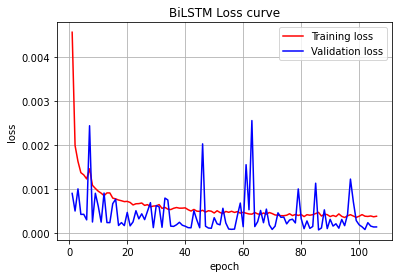

In [40]:
#画损失曲线图
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.title('BiLSTM Loss curve')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [41]:
sc_one = MinMaxScaler(feature_range = (0, 1))
sc_one.fit_transform(all_data.iloc[:, 1:2])
predicted_stock_train = regressorBiLSTM.predict(x_train)
predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
predicted_stock_test = regressorBiLSTM.predict(x_test)
predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)
real_price_train=sc_one.inverse_transform(np.reshape(y_train,(-1,1)))
real_price_test=sc_one.inverse_transform(np.reshape(y_test,(-1,1)))

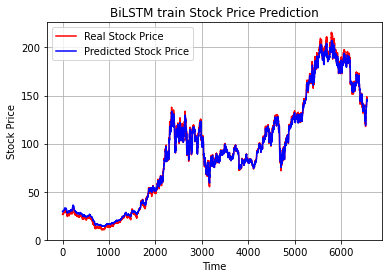

In [42]:
# Visualising the test results
plt.plot(real_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('BiLSTM train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

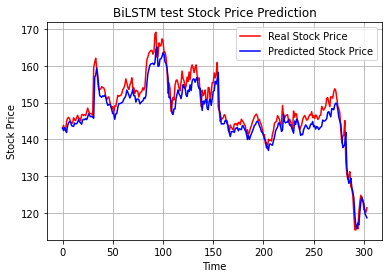

In [43]:
# Visualising the test results
plt.plot(real_price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('BiLSTM test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_test, real_price_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_stock_test, real_price_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_test, real_price_test)

r2=r2_score(predicted_stock_test, real_price_test)

print('BiLSTM模型的均方误差是: %.6f' % mse)
print('BiLSTM模型的均方根误差是: %.6f' % rmse)
print('BiLSTM模型的平均绝对误差是: %.6f' % mae)
print('BiLSTM模型的R-squared是: %.6f' % r2)

BiLSTM模型的均方误差是: 8.633169
BiLSTM模型的均方根误差是: 2.938226
BiLSTM模型的平均绝对误差是: 2.378653
BiLSTM模型的R-squared是: 0.883235
